## Overview
Notebook illustrating performance of a CNN classifier on MNIST dataset compared against generated data by simple GAN(simpGAN) and privGan

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from classifier.cnn_classifier import CNNClassifier
from privacygan import privacy_gan as pg
from privacygan.mnist import mnist_gan
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__, "device:", device)

/data/miniconda/envs/privGAN/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.4.1 device: cpu


## Retrieve train and test data from the MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
X = (train_ds.data.float() - 127.5) / 127.5
X = X.view(X.size(0), 1, 28, 28).numpy()
y = train_ds.targets.numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('train:', X_train.shape, 'val:', X_val.shape)


train: (48000, 1, 28, 28) val: (12000, 1, 28, 28)


In [3]:
clf = CNNClassifier(num_classes=10, input_shape=(1, 28, 28), device=device)
val_loss, val_acc = clf.train(X_train, y_train, X_val, y_val, batch_size=256, epochs=5)
print('Validation loss:', val_loss, 'Validation acc:', val_acc)
# 保存基线结果供后续对比
r_real = (val_loss, val_acc)

Validation loss: 0.04143974767128626 Validation acc: 0.98825


## Using SimpGan generate synthetic images 

In [4]:
# Evaluate on test split
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
X_test = (test_ds.data.float() - 127.5) / 127.5
X_test = X_test.view(X_test.size(0), 1, 28, 28).numpy()
y_test = test_ds.targets.numpy()

with torch.no_grad():
    xb = torch.tensor(X_test, dtype=torch.float32, device=device)
    logits = clf.model(xb)
    preds = logits.argmax(dim=1).cpu().numpy()
    test_acc = (preds == y_test).mean()
print('Test accuracy:', test_acc)


Test accuracy: 0.9891


In [5]:
# You can now reuse clf.model for downstream tasks or save it
# torch.save(clf.model.state_dict(), 'mnist_cnn.pth')


## Using privGan generate synthetic images

In [6]:
# 使用 privGAN 为每个类别生成合成图像（PyTorch 版本）
NUM_CLASSES = 10
randomDim = 100

X_c2 = []
y_c2 = []

for i in range(NUM_CLASSES):
    idx = np.where(y_train == i)[0]
    X_cls = X_train[idx]
    print(f"Class {i}: {len(X_cls)} samples")

    # 两个生成器和判别器 + 隐私判别器
    generators = [mnist_gan.MNIST_Generator(randomDim=randomDim), mnist_gan.MNIST_Generator(randomDim=randomDim)]
    discriminators = [mnist_gan.MNIST_Discriminator(), mnist_gan.MNIST_Discriminator()]
    pDisc = mnist_gan.MNIST_DiscriminatorPrivate(OutSize=2)

    # 训练 privGAN（为保持演示速度，epochs=1，disc_epochs=1）
    generators, discriminators, pDisc, dLosses, dpLosses, gLosses = pg.privGAN(
        X_cls,
        epochs=1,
        disc_epochs=1,
        batchSize=256,
        generators=generators,
        discriminators=discriminators,
        pDisc=pDisc,
        privacy_ratio=1.0,
    )

    # 生成合成样本（各一半）
    n_each = max(1, len(X_cls) // 2)
    z1 = torch.randn(n_each, randomDim)
    z2 = torch.randn(n_each, randomDim)
    with torch.no_grad():
        fake1 = generators[0](z1).cpu().numpy()
        fake2 = generators[1](z2).cpu().numpy()

    # 将 784 展平向量还原为 (N, 1, 28, 28)
    fake = np.concatenate([fake1, fake2], axis=0).reshape(-1, 1, 28, 28)
    X_c2.append(fake)
    y_c2.append(np.full(fake.shape[0], i, dtype=np.int64))

X_c2 = np.concatenate(X_c2, axis=0)
y_c2 = np.concatenate(y_c2, axis=0)
print('Synthetic set:', X_c2.shape, y_c2.shape)

Class 0: 4738 samples
dp-Accuracy: 0.5063317855635289
Epochs: 1
Batch size: 256
Batches per epoch: 10
epoch = 0/1, batch = 10/10
dLosses = [1.09799124 1.10632254]
dpLosses = 0.0
gLosses = 2.6827569246292113
dp-Accuracy: 0.0
Class 1: 5394 samples
dp-Accuracy: 0.5
Epochs: 1
Batch size: 256
Batches per epoch: 11
epoch = 0/1, batch = 11/11
dLosses = [1.08544774 1.08965465]
dpLosses = 0.0
gLosses = 2.6740826801820234
dp-Accuracy: 0.5
Class 2: 4766 samples
dp-Accuracy: 0.5
Epochs: 1
Batch size: 256
Batches per epoch: 10
epoch = 0/1, batch = 10/10
dLosses = [1.10139148 1.08133368]
dpLosses = 0.0
gLosses = 2.6845192909240723
dp-Accuracy: 0.5
Class 3: 4905 samples
dp-Accuracy: 0.5039755351681957
Epochs: 1
Batch size: 256
Batches per epoch: 10
epoch = 0/1, batch = 10/10
dLosses = [1.08291345 1.10880828]
dpLosses = 0.0
gLosses = 2.682564210891724
dp-Accuracy: 0.0
Class 4: 4674 samples
dp-Accuracy: 0.5
Epochs: 1
Batch size: 256
Batches per epoch: 10
epoch = 0/1, batch = 10/10
dLosses = [1.09290233

In [7]:
## Shuffle labels around
arr = np.arange(len(X_c2))
np.random.shuffle(arr)
X_c2 = X_c2[arr]
y_c2 = y_c2[arr]

In [8]:
# 使用合成数据训练一个新的 CNN 分类器并在真实测试集上评估
clf_priv = CNNClassifier(num_classes=10, input_shape=(1, 28, 28), device=device)
val_loss_priv, val_acc_priv = clf_priv.train(X_c2, y_c2, X_test, y_test, batch_size=256, epochs=5)
print('privGAN Test loss:', val_loss_priv)
print('privGAN Test accuracy:', val_acc_priv)
r_2 = (val_loss_priv, val_acc_priv)

privGAN Test loss: 4.106789469909668
privGAN Test accuracy: 0.7395


## Plot the results of the CNN classifier on the three datasets

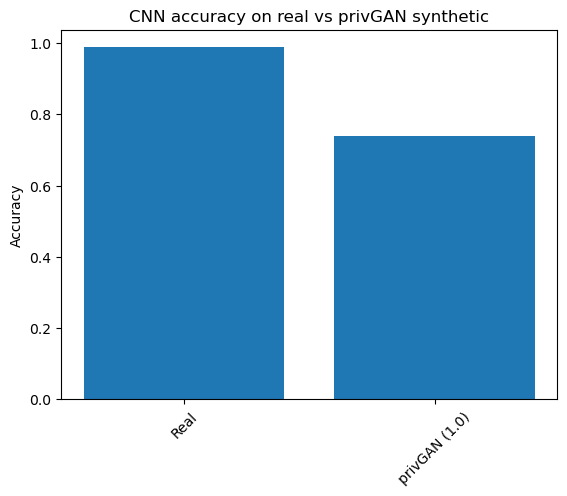

In [9]:
# 对比基线（真实数据训练）与 privGAN（合成数据训练）
labels = ['Real', 'privGAN (1.0)']
accs = [r_real[1], r_2[1]]
plt.bar(range(len(labels)), accs)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylabel('Accuracy')
plt.title('CNN accuracy on real vs privGAN synthetic')
plt.show()